## Dose Response Curve Fitting in Python
### Setting up the stage
While I would naturally fit dose-response curves in R using drc, recently I have started using iPython more and more and was wondering : "Can I do curve fitting in Python directly?"

Turns out this is quite easy, although not necessarily well documented. Let's create a toy example and see how things are done using scipy.optimize & pandas

retreived from: https://gist.github.com/yannabraham/5f210fed773785d8b638?permalink_comment_id=1713810#file-doseresponsepython-ipynb 

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings

def action_with_warnings():
    warnings.warn("should not appear")

Let's use a 4-parameter sigmoidal function as a starting point:

In [3]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

## Loading my own data

In [4]:
BaseDir = './results/'

In [5]:
dfViability = pd.read_csv("{}/viability_scores.csv".format(BaseDir), sep=";", index_col=0)
#dfViability.head()

In [6]:
# Add a log concentration column
dfViability['Metadata_log_conc'] = pDose(dfViability['Metadata_cmpd_conc'])
dfViability.head(1)

,Count_nuclei,ObjectNumber_cells,ObjectNumber_nuclei,AreaOccupied_AreaOccupied_cells,Metadata_layout_id,Metadata_well_id,Metadata_batch_id,Metadata_solvent,Metadata_stock_conc,Metadata_stock_conc_unit,...,Metadata_batchid,Metadata_cbkid,Metadata_libid,Metadata_libtxt,Metadata_smiles,Metadata_inchi,Metadata_inkey,Metadata_cmpd,Metadata_plate_well,Metadata_log_conc
0,71.940079,70.045998,82.82424,72.489899,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B02,PHB000015,dmso,10.0,mM,...,PHB000015,[tetr],[tetr],pharmb_io,NaN,NaN,NaN,[tetr],colo44-v1-FA-P017365-CACO2-48h-P1-L1_B02,5.60206


In [16]:
ListOfFeatures = ['Count_nuclei', 'ObjectNumber_cells', 'ObjectNumber_nuclei', 'AreaOccupied_AreaOccupied_cells']

# Remove the reference compounds for now
dfViability = dfViability.loc[dfViability['Metadata_pert_type'] == 'trt']
ListOfCompounds = list(dfViability['Metadata_cmpd'].unique())
ListOfCompounds.remove('AMG 23')


# Prepare a list of concentrations
listOfConc = list(dfViability['Metadata_cmpd_conc'].unique())
listOfConc.sort()
listOfConc = list(map("{:.2f}".format,listOfConc))

# Prepare a list of concentrations in log format. OBS they sort in the opposite direction.
listOfLogConc = dfViability['Metadata_log_conc'].unique()
listOfLogConc.sort()
listOfLogConc = listOfLogConc[::-1]
 

In [17]:
dfToplot = dfViability[dfViability['Metadata_cmpd'].isin(ListOfCompounds)]
feature = ListOfFeatures[0]


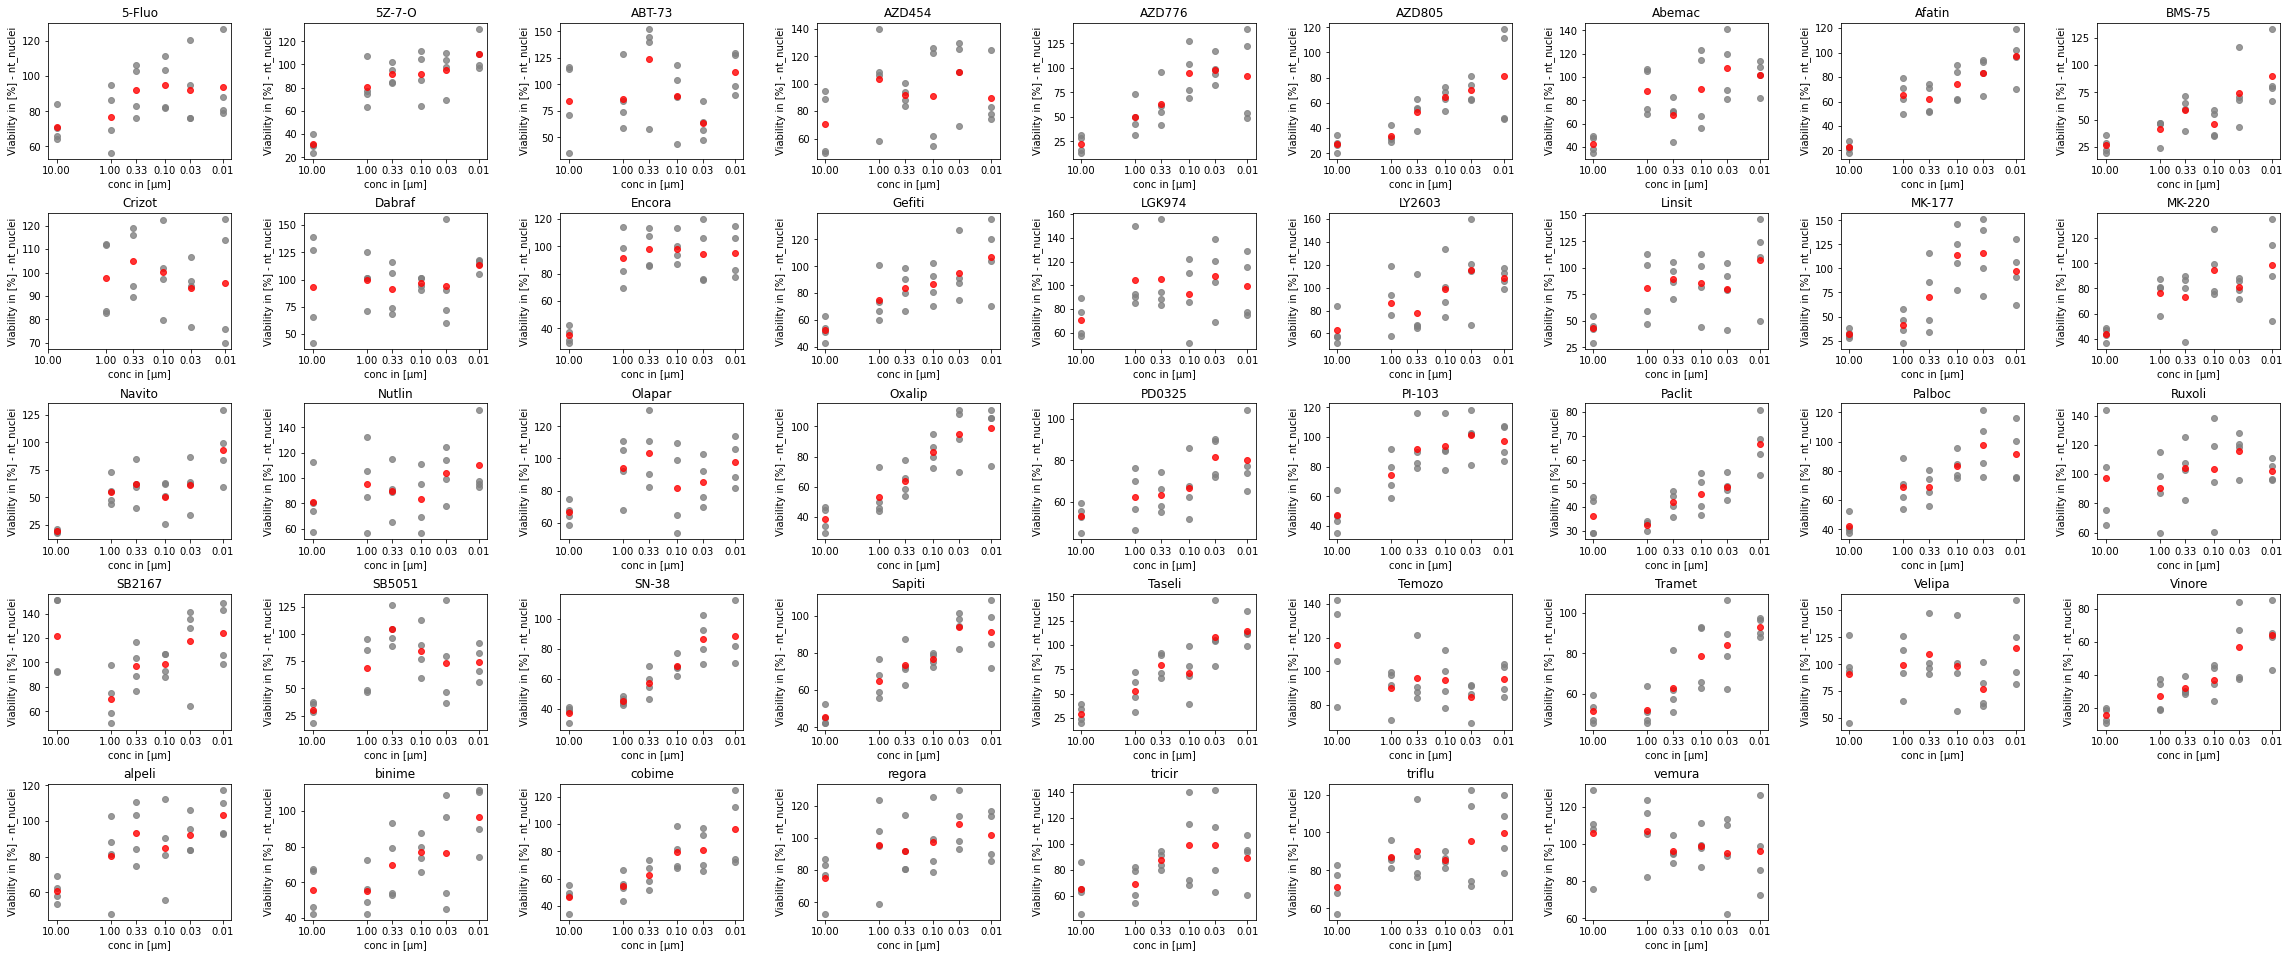

In [18]:
compoundData = dfToplot.groupby(['Metadata_cmpd'])

nrrow = 6 
nrcol = 9
sp = 1

fig = plt.figure(figsize = (40,20))
for compound in compoundData:

    meandata = compound[1].groupby('Metadata_cmpd_conc').mean()

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_title(compound[0])
    sns.regplot(ax=ax, x='Metadata_log_conc',y=feature,data=compound[1],color='gray', fit_reg=False) # plot the compounds 
    sns.regplot(ax=ax, x='Metadata_log_conc',y=feature,data=meandata,color='red', fit_reg=False) # add the mean data
    plt.gca().invert_xaxis()
    ax.xaxis.set_ticks(listOfLogConc)
    ax.set_xticklabels(listOfConc)

    ax.set_xlabel('conc in [µm]')
    ax.set_ylabel('Viability in [%] - ' + feature[-9:])

    ax.invert_xaxis()

    sp +=1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

## Fitting the curve
is as simple as

In [19]:
fitData = []
for name,group in compoundData:
    try:
        fitCoefs, covMatrix = opt.curve_fit(ll4, group.Metadata_cmpd_conc, group[feature])
        resids = group[feature]-group.Metadata_cmpd_conc.apply(lambda x: ll4(x,*fitCoefs))
        curFit = dict(zip(['b','c','d','e'],fitCoefs))
        curFit['Metadata_cmpd']=name
        curFit['residuals']=sum(resids**2)
        fitData.append(curFit)
    except: 
        print('The fit failed for {}'.format(name))
fitCompound = [item['Metadata_cmpd'] for item in fitData]


/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_10084/3180035174.py:7: RuntimeWarning: invalid value encountered in log
  return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))


The fit failed for Abemac
The fit failed for Afatin
The fit failed for BMS-75
The fit failed for Gefiti
The fit failed for Navito
The fit failed for Nutlin
The fit failed for PD0325
The fit failed for Paclit
The fit failed for alpeli
The fit failed for binime
The fit failed for regora
The fit failed for triflu


In [23]:
fitTable = pd.DataFrame(fitData).set_index('Metadata_cmpd')
dfFit = dfToplot.loc[dfToplot['Metadata_cmpd'].isin(fitTable.index.unique())]
#fitTable

In [ ]:
# refDose = np.linspace(min(dfFit.Metadata_log_conc)*0.9,max(dfFit.Metadata_log_conc)*1.1,256)
# refDose = (10**-refDose)*1e6
# sns.lmplot(x='Metadata_log_conc',y=feature,data=dfFit,hue='Metadata_cmpd',fit_reg=False)
# for fit in fitData:
#     plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_10084/1525536385.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listOfConc)


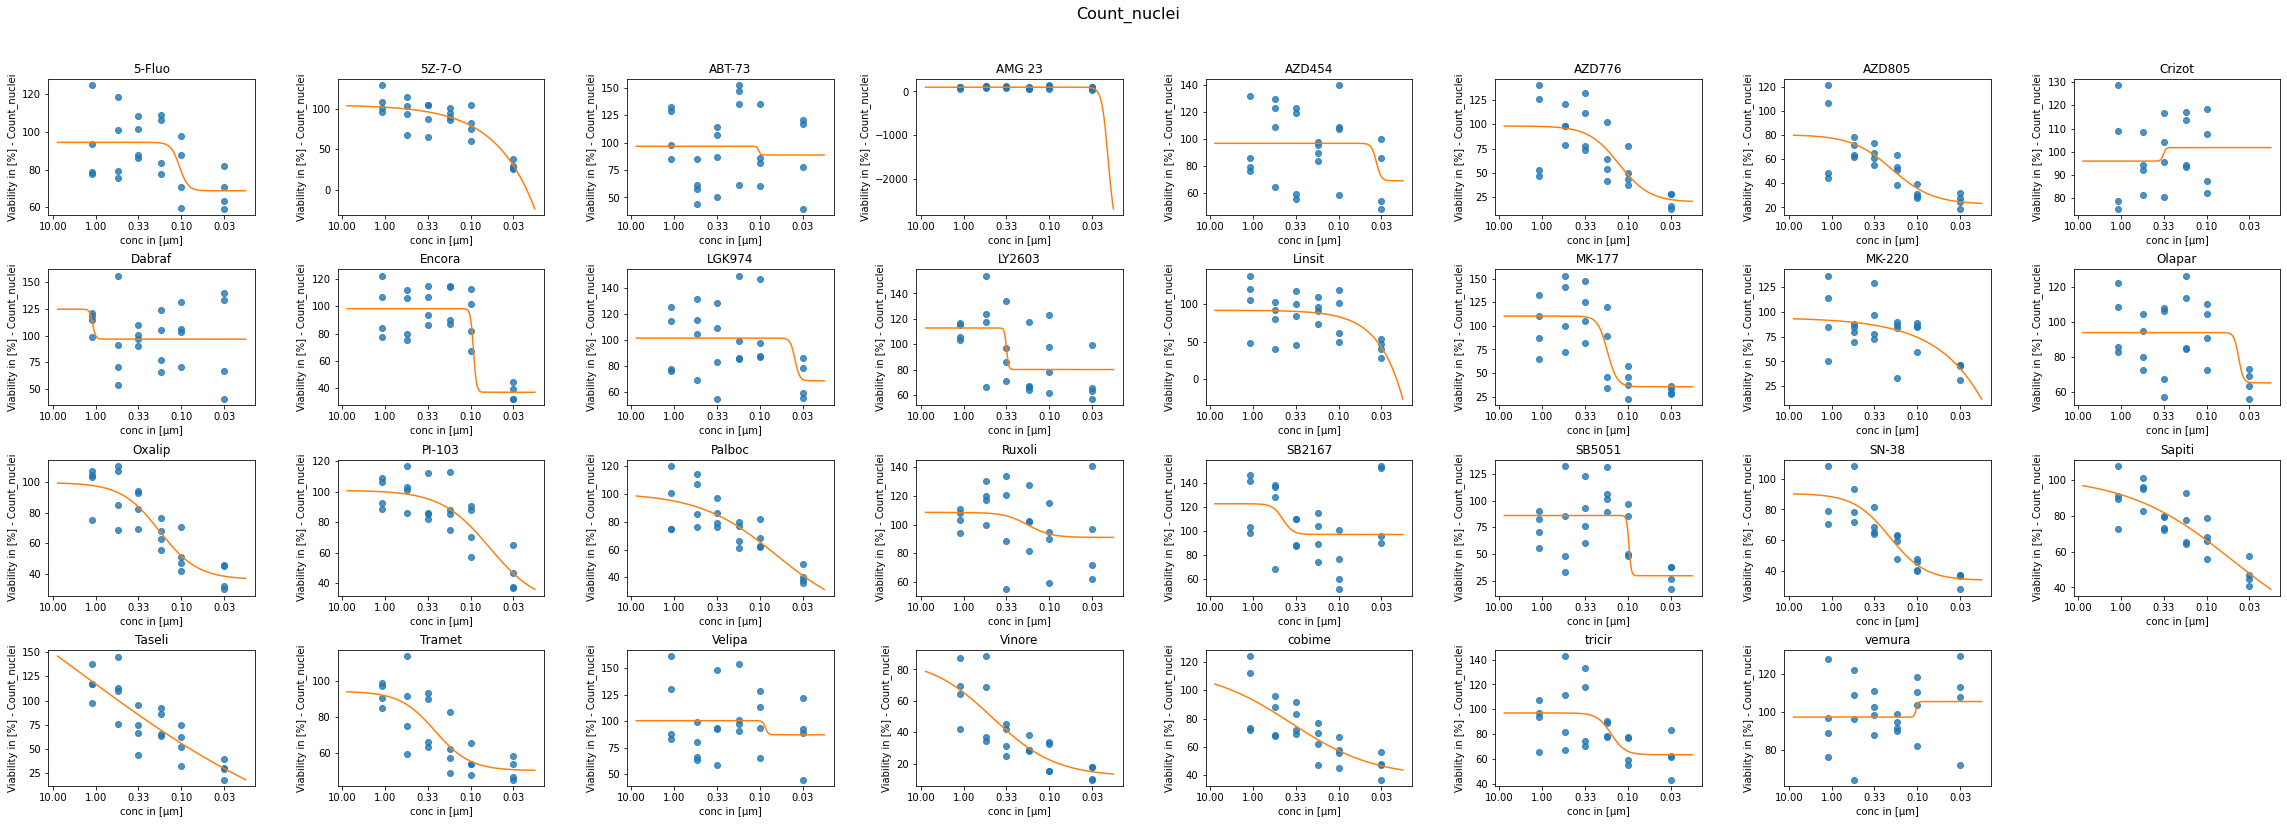

In [15]:
refDose = np.linspace(min(dfFit.Metadata_log_conc)*0.9,max(dfFit.Metadata_log_conc)*1.1,256)
refDose = (10**-refDose)*1e6

nrrow = 6 
nrcol = 8
sp = 1

fig = plt.figure(figsize = (40,20))
fig.suptitle('{}'.format(feature), fontsize = 16, y=0.93)

for ii in range(len(fitData)):
    ax = fig.add_subplot(nrrow, nrcol, sp)
    sns.regplot(ax=ax, x='Metadata_log_conc',y=feature,data=dfFit[dfFit['Metadata_cmpd'] == fitData[ii].get('Metadata_cmpd')],fit_reg=False)
    fit = fitData[ii]
    plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])
    ax.set_title(fitData[ii].get('Metadata_cmpd'))
    plt.gca().invert_xaxis()
    ax.set_xticklabels(listOfConc)
    ax.set_xlabel('conc in [µm]')
    ax.set_ylabel('Viability in [%] - ' + feature)
    sp += 1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

In [ ]:
compoundData = dfToplot.groupby(['Metadata_cmpd'])

nrrow = 6 
nrcol = 9
sp = 1

fig = plt.figure(figsize = (40,20))
for compound in compoundData:

    meandata = compound[1].groupby('Metadata_cmpd_conc').mean()

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_title(compound[0])
    sns.regplot(ax=ax, x='Metadata_log_conc',y='ObjectNumber_cells',data=compound[1],color='gray', fit_reg=False) # plot the compounds 
    sns.regplot(ax=ax, x='Metadata_log_conc',y='ObjectNumber_cells',data=meandata,color='red', fit_reg=False) # add the mean data
    plt.gca().invert_xaxis()
    ax.xaxis.set_ticks(listOfLogConc)
    ax.set_xticklabels(listOfConc)

    ax.set_xlabel('conc in [µm]')
    ax.set_ylabel('Viability in [%] - ' + feature[-9:])

    ax.invert_xaxis()

    sp +=1
plt.subplots_adjust( wspace=0.4, hspace=0.4)